In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

from collections import OrderedDict
from tqdm import tqdm  # For progress bar
import tarfile

from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
RANDOM_SEED = 159

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Define dataset directory
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
data_dir = "./flowers_dataset"

In [11]:
# Create directory if not exists
os.makedirs(data_dir, exist_ok=True)

# Function to download dataset
def download_dataset(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url} ...")
        torch.hub.download_url_to_file(url, save_path)
        print(f"Saved to {save_path}")
    else:
        print(f"File already exists: {save_path}")

# Function to extract the dataset
def extract_dataset(dataset_path, file_path, extract_path):
    if not os.path.exists(dataset_path):
        print(f"Extracting {file_path}...")
        with tarfile.open(file_path, 'r:gz') as tar:
             tar.extractall(path=extract_path)
        print(f"Extracted to {extract_path}")
    else:
        print(f"Dataset already extracted to {extract_path}")

# Download dataset and labels
download_dataset(dataset_url, os.path.join(data_dir, "102flowers.tgz"))
download_dataset(labels_url, os.path.join(data_dir, "imagelabels.mat"))
# Extract the dataset
dataset_path = '/kaggle/working/flowers_dataset/jpg'
dataset_tgz = '/kaggle/working/flowers_dataset/102flowers.tgz'
extract_dataset(dataset_path, dataset_tgz, data_dir)

print("Dataset setup complete.")

100%|██████████| 329M/329M [00:10<00:00, 34.1MB/s] 


Saved to ./flowers_dataset/102flowers.tgz


100%|██████████| 502/502 [00:00<00:00, 724kB/s]


Saved to ./flowers_dataset/imagelabels.mat
Extracting /kaggle/working/flowers_dataset/102flowers.tgz...
Extracted to ./flowers_dataset
Dataset setup complete.


In [12]:
# Set dataset directory
data_dir = "./flowers_dataset"
images_dir = dataset_path
labels_path = os.path.join(data_dir, "imagelabels.mat")

# Load labels
labels = scipy.io.loadmat(labels_path)["labels"][0]  # Convert to array
labels -= 1  # Convert labels to zero-based indexing (0-101 instead of 1-102)

In [13]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNN models
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(15),  # Augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [14]:
# Custom Dataset Class
class FlowerDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))  # Ensure order matches labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Load full dataset
dataset = FlowerDataset(images_dir, labels, transform=train_transform)

# Split dataset into train (50%), validation (25%), and test (25%)
total_size = len(dataset)
train_size = int(0.5 * total_size)
val_size = int(0.25 * total_size)
test_size = total_size - train_size - val_size  # Ensure full coverage

# Random split with different seed for reproducibility
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                         generator=torch.Generator().manual_seed(RANDOM_SEED))

In [16]:
# Apply different transforms for test & validation sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [17]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17270/17270), 16.12 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 15.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6096.0/8062.4 GB disk)


In [19]:
import shutil
# Define new dataset directory
dataset_root = "./yolov5/data/flowers_dataset"
os.makedirs(dataset_root, exist_ok=True)

# Define subfolders
splits = ["train", "valid", "test"]
for split in splits:
    for label in range(102):  # 102 classes
        os.makedirs(os.path.join(dataset_root, split, f"class_{label}"), exist_ok=True)

# Helper function to move images
def move_images(dataset, split):
    for idx in range(len(dataset)):
        # Get the correct full path of the image
        img_filename = dataset.dataset.image_files[dataset.indices[idx]]
        img_path = os.path.join(images_dir, img_filename)  # Ensure full path
        
        # Get the label and define destination
        label = dataset.dataset.labels[dataset.indices[idx]]
        dest_path = os.path.join(dataset_root, split, f"class_{label}", img_filename)
        
        # Check if the image exists before copying
        if os.path.exists(img_path):
            shutil.copy(img_path, dest_path)
        else:
            print(f"Warning: Image {img_path} not found! Skipping...")

# Move images based on train/val/test split
move_images(train_dataset, "train")
move_images(val_dataset, "valid")
move_images(test_dataset, "test")

print("Dataset restructured for YOLOv5 classification!")

Dataset restructured for YOLOv5 classification!


In [20]:
!python classify/train.py --model yolov5s-cls.pt --data ./yolov5/data/flowers_dataset --epochs 30 --img 224 --batch 32 --name test


2025-01-31 13:20:45.406489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 13:20:45.807419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 13:20:45.942450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
classify/train: model=yolov5s-cls.pt, data=./yolov5/data/flowers_dataset, epochs=30, batch_size=32, imgsz=224, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=test, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to d

In [27]:
!python classify/val.py --weights runs/train-cls/test/weights/best.pt --data ./yolov5/data/flowers_dataset --img 224 --name test


classify/val: data=./yolov5/data/flowers_dataset, weights=['runs/train-cls/test/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing:   0%|          | 0/16 [00:00<?, ?it/s]/kaggle/working/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
testing: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2048       0.977       0.997
                 class_0           9           1           1
                 class_1           9           1           1
            

In [34]:
data = [
    ["Class", "Images", "top1_acc", "top5_acc"],
    ["all", 2048, 0.977, 0.997],
    ["class_0", 9, 1, 1],
    ["class_1", 9, 1, 1],
    ["class_10", 22, 1, 1],
    ["class_100", 16, 1, 1],
    ["class_101", 10, 1, 1],
    ["class_11", 23, 1, 1],
    ["class_12", 11, 1, 1],
    ["class_13", 11, 1, 1],
    ["class_14", 11, 1, 1],
    ["class_15", 12, 1, 1],
    ["class_16", 18, 1, 1],
    ["class_17", 18, 1, 1],
    ["class_18", 13, 0.923, 0.923],
    ["class_19", 14, 0.929, 1],
    ["class_2", 10, 0.8, 1],
    ["class_20", 7, 1, 1],
    ["class_21", 16, 1, 1],
    ["class_22", 25, 1, 1],
    ["class_23", 11, 0.909, 1],
    ["class_24", 9, 1, 1],
    ["class_25", 11, 0.909, 1],
    ["class_26", 12, 1, 1],
    ["class_27", 16, 1, 1],
    ["class_28", 16, 0.938, 1],
    ["class_29", 17, 0.941, 1],
    ["class_3", 12, 0.75, 0.917],
    ["class_30", 14, 0.929, 1],
    ["class_31", 11, 0.909, 1],
    ["class_32", 13, 1, 1],
    ["class_33", 14, 0.929, 1],
    ["class_34", 9, 1, 1],
    ["class_35", 25, 1, 1],
    ["class_36", 34, 1, 1],
    ["class_37", 11, 1, 1],
    ["class_38", 8, 1, 1],
    ["class_39", 15, 0.933, 0.933],
    ["class_4", 21, 0.905, 1],
    ["class_40", 31, 1, 1],
    ["class_41", 18, 1, 1],
    ["class_42", 27, 0.926, 1],
    ["class_43", 23, 1, 1],
    ["class_44", 9, 1, 1],
    ["class_45", 48, 1, 1],
    ["class_46", 8, 1, 1],
    ["class_47", 21, 0.952, 1],
    ["class_48", 9, 1, 1],
    ["class_49", 20, 1, 1],
    ["class_5", 7, 1, 1],
    ["class_50", 59, 1, 1],
    ["class_51", 27, 1, 1],
    ["class_52", 23, 1, 1],
    ["class_53", 16, 1, 1],
    ["class_54", 14, 1, 1],
    ["class_55", 33, 1, 1],
    ["class_56", 17, 1, 1],
    ["class_57", 35, 1, 1],
    ["class_58", 17, 1, 1],
    ["class_59", 31, 1, 1],
    ["class_6", 11, 1, 1],
    ["class_60", 11, 1, 1],
    ["class_61", 11, 0.818, 1],
    ["class_62", 13, 1, 1],
    ["class_63", 11, 1, 1],
    ["class_64", 27, 1, 1],
    ["class_65", 11, 1, 1],
    ["class_66", 10, 0.9, 1],
    ["class_67", 14, 0.929, 1],
    ["class_68", 11, 0.909, 0.909],
    ["class_69", 14, 1, 1],
    ["class_7", 22, 1, 1],
    ["class_70", 24, 1, 1],
    ["class_71", 27, 0.963, 1],
    ["class_72", 56, 1, 1],
    ["class_73", 38, 1, 1],
    ["class_74", 25, 0.96, 1],
    ["class_75", 28, 0.929, 1],
    ["class_76", 73, 1, 1],
    ["class_77", 35, 1, 1],
    ["class_78", 12, 1, 1],
    ["class_79", 31, 1, 1],
    ["class_8", 9, 0.889, 1],
    ["class_80", 43, 1, 1],
    ["class_81", 32, 0.938, 1],
    ["class_82", 32, 1, 1],
    ["class_83", 26, 0.962, 1],
    ["class_84", 16, 0.938, 0.938],
    ["class_85", 5, 0.8, 1],
    ["class_86", 12, 1, 1],
    ["class_87", 43, 1, 1],
    ["class_88", 47, 1, 1],
    ["class_89", 17, 1, 1],
    ["class_9", 11, 1, 1],
    ["class_90", 16, 1, 1],
    ["class_91", 21, 0.857, 1],
    ["class_92", 13, 1, 1],
    ["class_93", 38, 1, 1],
    ["class_94", 37, 0.919, 0.973],
    ["class_95", 17, 0.765, 1],
    ["class_96", 22, 0.909, 1],
    ["class_97", 22, 1, 1],
    ["class_98", 15, 1, 1],
    ["class_99", 12, 1, 1]
]

# Convert to a Pandas DataFrame
test_results = pd.DataFrame(data[1:], columns=data[0])

,Class,Images,top1_acc,top5_acc
0,all,2048,0.977,0.997
1,class_0,9,1.000,1.000
2,class_1,9,1.000,1.000
3,class_10,22,1.000,1.000
4,class_100,16,1.000,1.000


29

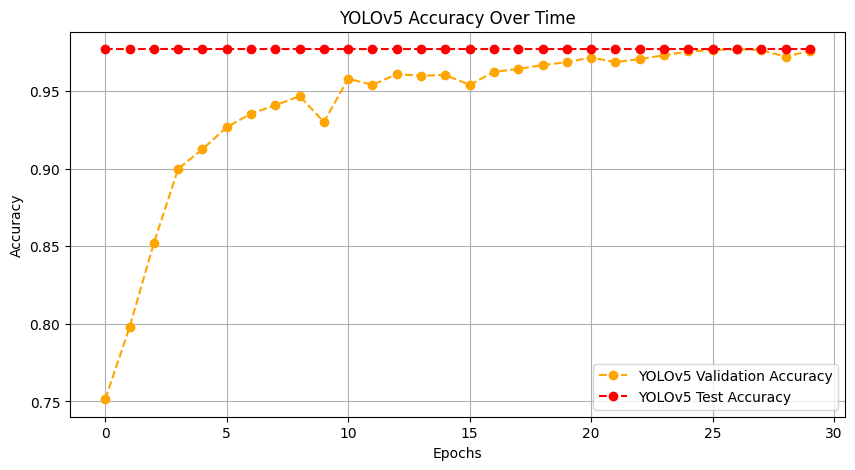

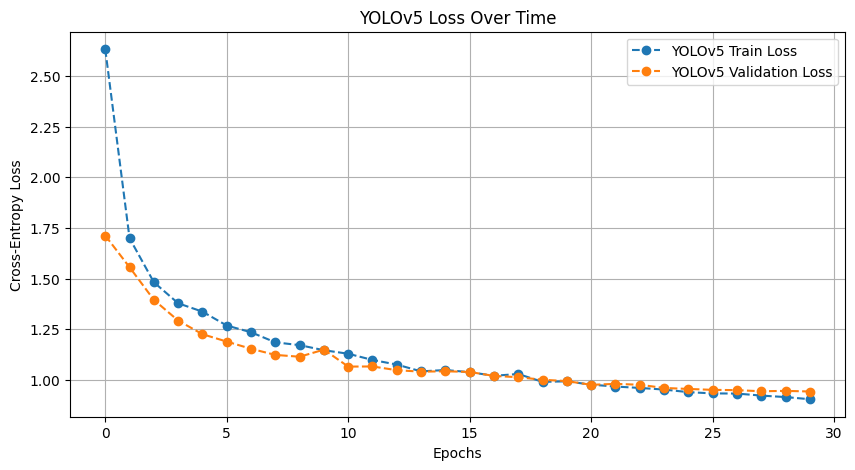

In [52]:
# Path to YOLOv5 training results
yolo_results_path = "runs/train-cls/test/results.csv"

# Load CSV file
train_results = pd.read_csv(yolo_results_path)

# Extract metrics
epochs = train_results["                  epoch"]
# yolov5_train_accuracies = train_results["  metrics/accuracy_top1"]
yolov5_val_accuracies = train_results["  metrics/accuracy_top1"]
yolov5_test_accuracies = [test_results.loc[0, "top1_acc"]] * (epochs.max()+1)
yolov5_train_losses = train_results["             train/loss"]
yolov5_val_losses = train_results["              test/loss"]

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
# plt.plot(epochs, yolov5_train_accuracies, label="YOLOv5 Train Accuracy", linestyle='dashed', marker='o')
plt.plot(epochs, yolov5_val_accuracies, label="YOLOv5 Validation Accuracy", linestyle='dashed', marker='o', color="orange")
plt.plot(epochs, yolov5_test_accuracies, label="YOLOv5 Test Accuracy", linestyle='dashed', marker='o', color="red")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("YOLOv5 Accuracy Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, yolov5_train_losses, label="YOLOv5 Train Loss", linestyle='dashed', marker='o')
plt.plot(epochs, yolov5_val_losses, label="YOLOv5 Validation Loss", linestyle='dashed', marker='o')
# plt.plot(epochs, test_results[0]['top1_acc'], label="Test Accuracy", linestyle='dashed', marker='o', color="red")

plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("YOLOv5 Loss Over Time")
plt.legend()
plt.grid()
plt.show()

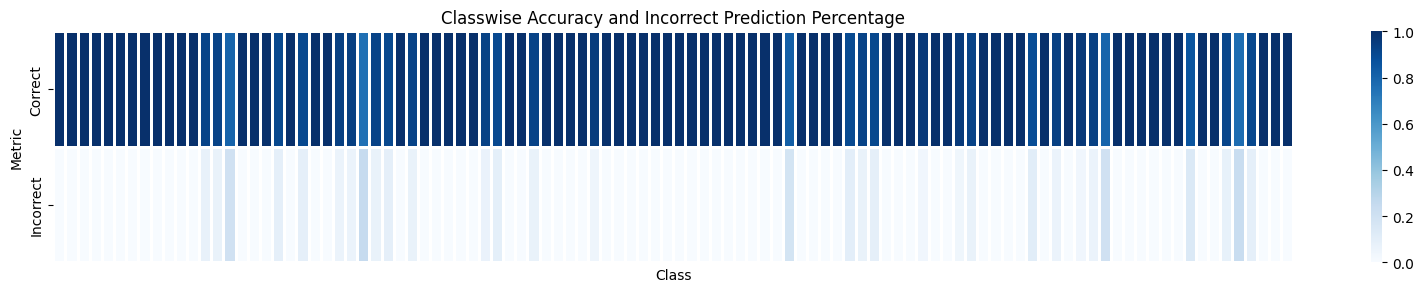

In [74]:
yolov5_conf_matrix = test_results.loc[1:,['Class','top1_acc']]
yolov5_conf_matrix['wrong_pred'] = 1 -test_results['top1_acc']

# Create a matrix with two columns: correct and wrong prediction percentages
heatmap_data = yolov5_conf_matrix[['top1_acc', 'wrong_pred']].set_index(yolov5_conf_matrix['Class'])

# Plot the heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data.T, annot=False, cmap='Blues', cbar=True, linewidths=1, xticklabels=[], yticklabels=['Correct', 'Incorrect'] )
plt.title('Classwise Accuracy and Incorrect Prediction Percentage')
plt.ylabel('Metric')
plt.xlabel('Class')
plt.show()

KeyboardInterrupt: 

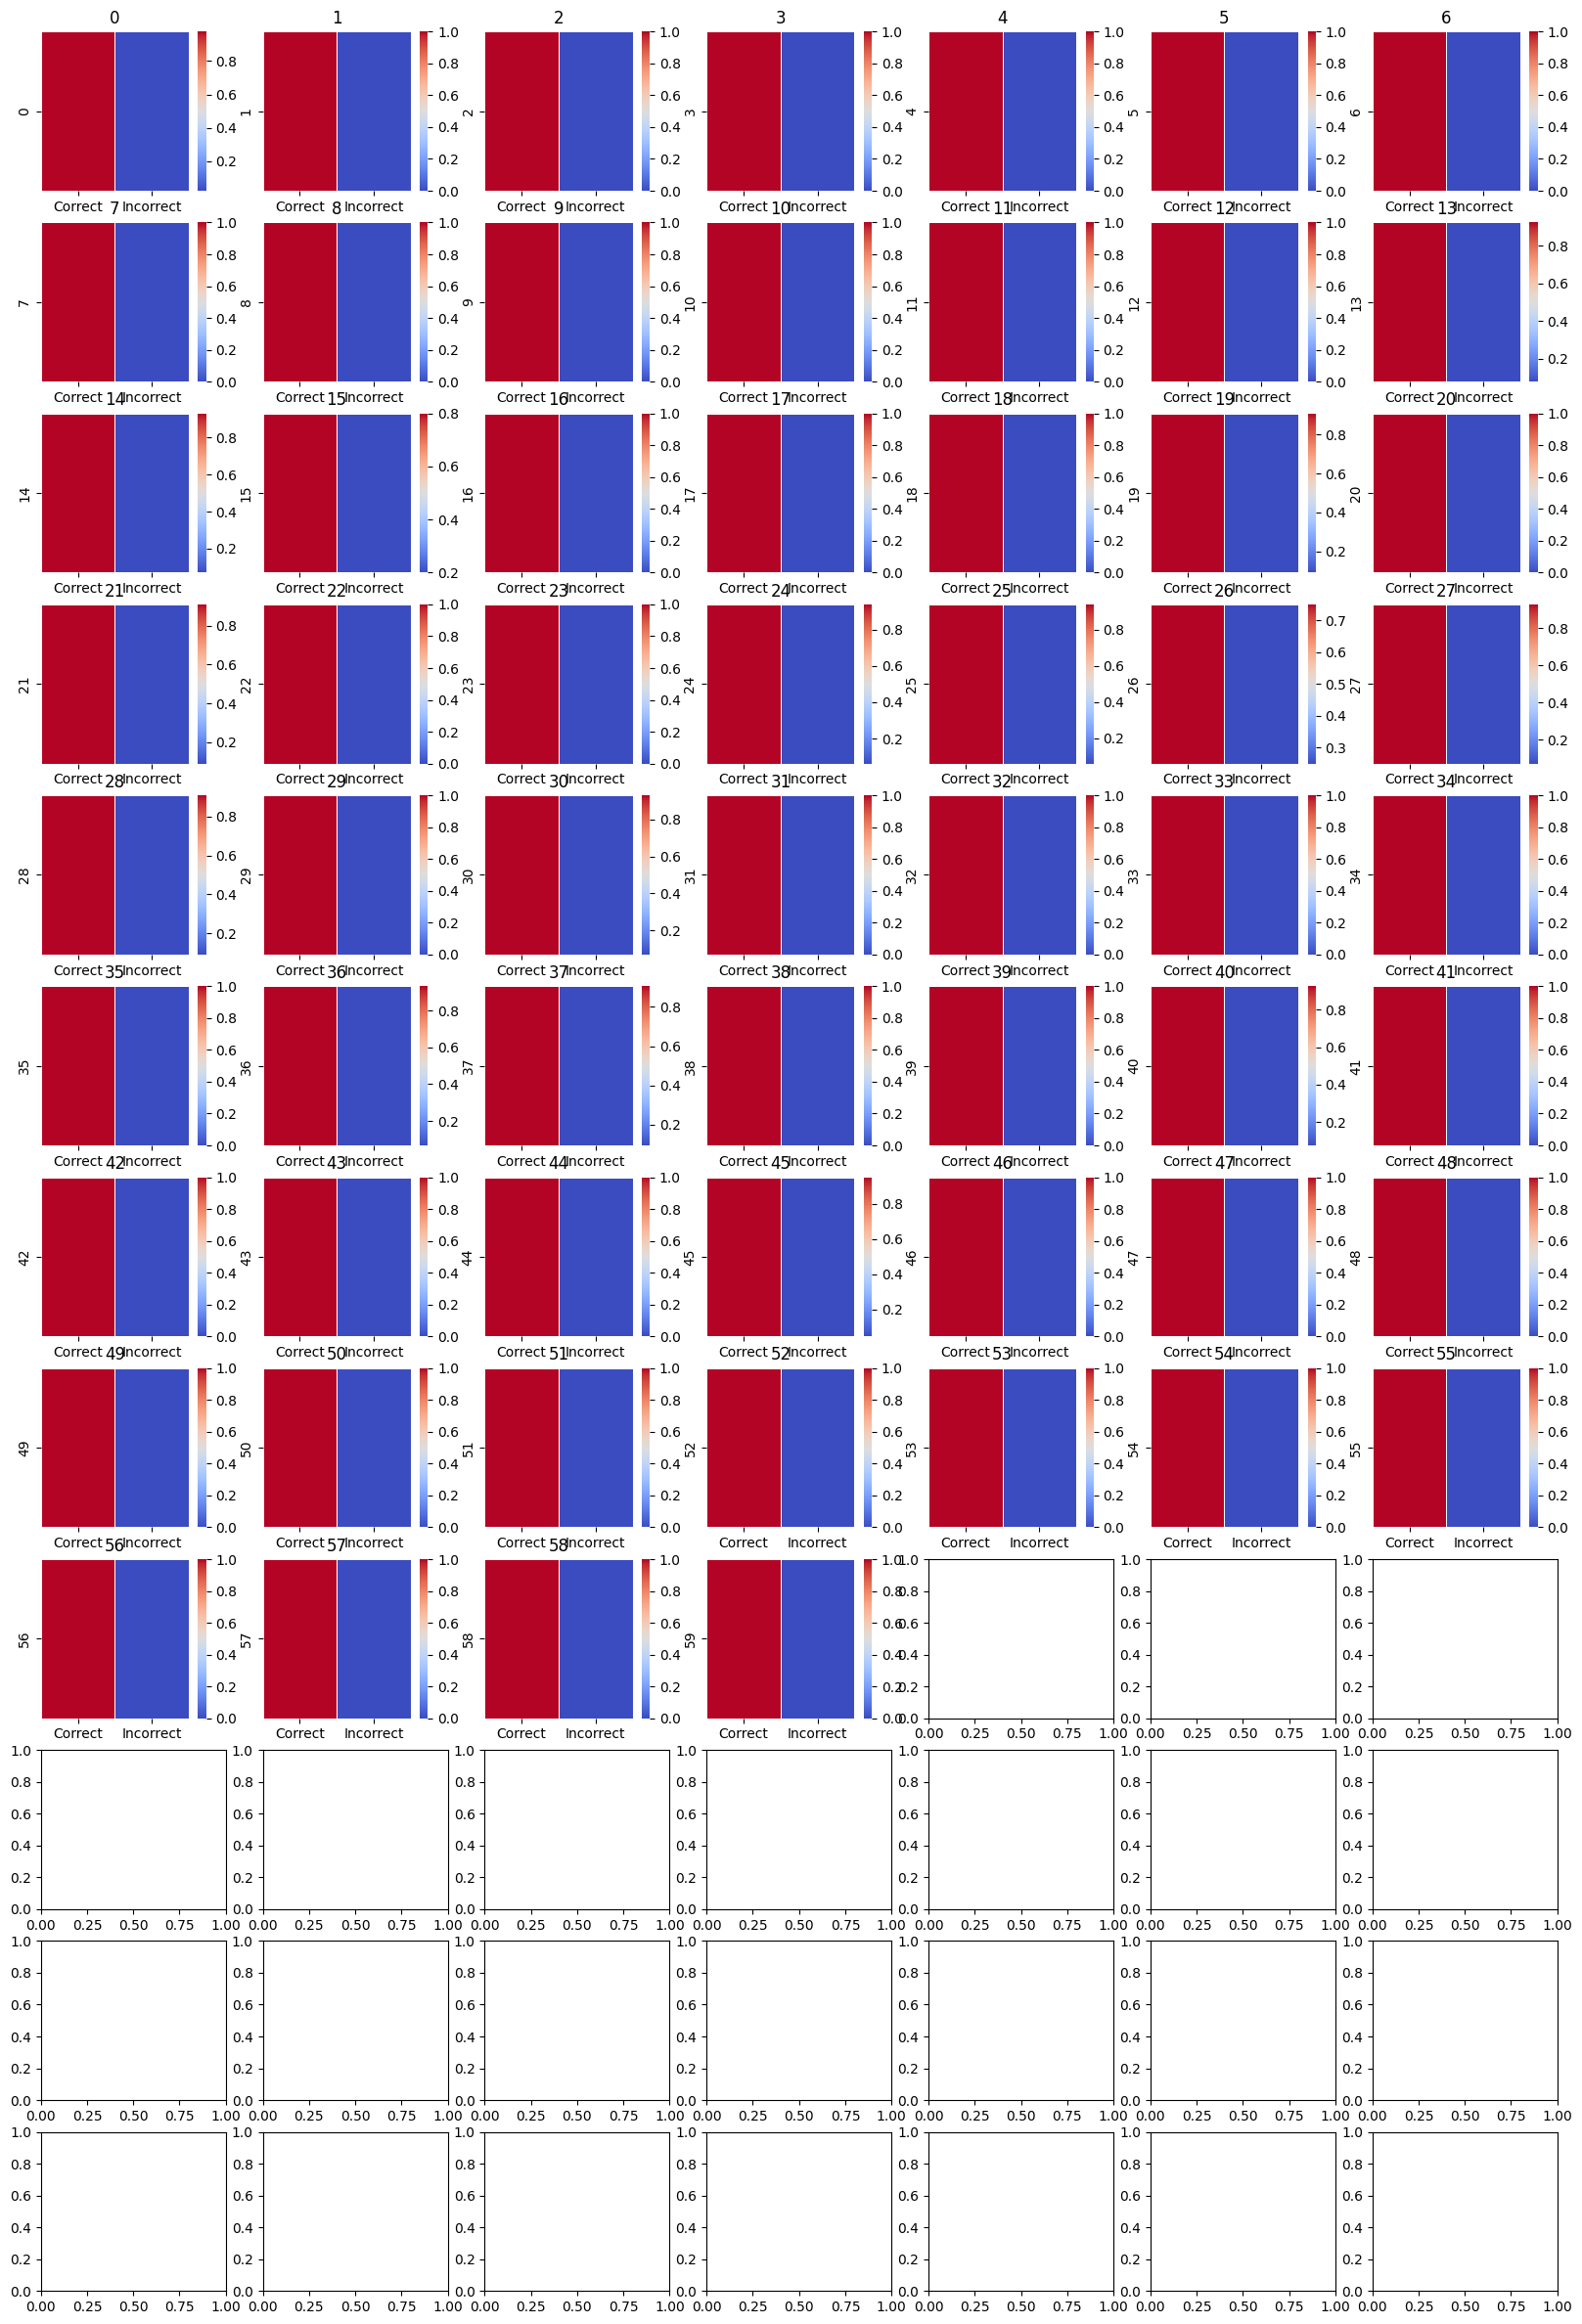

In [60]:
# Plotting
fig, axes = plt.subplots(nrows=12, ncols=7, figsize=(20, 30))  # 12 rows, 7 columns of subplots
axes = axes.flatten()  # Flatten the axes array to iterate over easily

# Loop through each class and create an individual heatmap
for i, (class_name, row) in enumerate(yolov5_conf_matrix.iterrows()):
    sns.heatmap(
        [[row['top1_acc'], row['wrong_pred']]], 
        ax=axes[i], 
        annot=False, 
        cmap='coolwarm', 
        cbar=True, 
        linewidths=0.5,
        xticklabels=['Correct', 'Incorrect'],
        yticklabels=[class_name]
    )
    axes[i].set_title(class_name)

# Adjust layout for better display
plt.tight_layout()
plt.show()